## Rainy Weekend with Autoencoders

~** *POST UNDER CONSTRUCTION* **~

I'm spending this rainy weekend learning about autoencoders using TensorFlow and Keras in Python. I'm particularly interested in one kind of autoencoder called a *variational autoencoder* (because I think it might be useful in my thesis project - more on that in another post) but before I get there, let's back up and nail down some basics...

### *What is autoencoding?*
Autoencoding is much like what it sounds in the sense that the input and 'output' are essentially the same. It's an algorithm for data compression where the functions for compression and decompression are *learned from the data*. It's considered more of a *semi-supervised* learning method as opposed to a truly *unsupervised* one since it's not entirely 'targetless'. Instead it learns the targets from the data itself.

Despite all this talk of data compression, autoencoders aren't typically used for that purpose. In practice, you're much more likely to see them being used to preprocess data (as in denoising - think images but it doesn't have to be ;) ) or for dimensionality reduction. In fact, the hidden layers of simple autoencoders are doing something like principal component analysis (PCA), another method traditionally used for dimensionality reduction.

### *Autoencoders*
Generally autoencoders have three parts: an encoder, a decoder, and a 'loss' function that maps one to the other. For the simplest autoencoders - the sort that compress and then reconstruct the original inputs from the compressed representation - we can think of the 'loss' as describing the amount of information lost in the process of reconstruction. Typically when people are talking about autoencoders, they're talking about ones where the encoders and decoders are neural networks (in our case deep convnets). In training the autoencoder, we're optimizing the parameters of the neural networks to minimize the 'loss' (or distance) and we do that by stochastic gradient descent (yet another topic for another post). 

### *The Variational Variety*
There's a bunch of different kinds of autoencoders but for this post I'm going to concentrate on one type called a *variational autoencoder*. Variational autoencoders (VAEs) don't learn to morph the data in and out of a compressed representation of itself like the 'vanilla' autoencoders I described above. Instead, they learn the parameters of the probability distribution that the data came from. These types of autoencoders have much in common with latent factor analysis (if you know something about that). The encoder and decoder learn models that are in terms of underlying, unobserved *latent* variables. 

VAEs have received a lot of attention in recent years because of their *generative* ability. Since they learn about the distribution the inputs came from, we can sample from that distribution to generate novel data. As we'll see, VAEs can also be used to cluster data in useful ways.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

from scipy.stats import norm

import keras
from keras import layers
from keras.models import Model
from keras import metrics
from keras import backend as K   # 'generic' backend so code works with either tensorflow or theano

K.clear_session()

Using TensorFlow backend.


In [2]:
# check devices 
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3909741481679060643, name: "/gpu:0"
 device_type: "GPU"
 memory_limit: 1576065433
 locality {
   bus_id: 1
 }
 incarnation: 5632460008122564049
 physical_device_desc: "device: 0, name: GeForce GT 730, pci bus id: 0000:01:00.0"]

Let's get the data. I'm working with the MNIST data in the context of the [Digit Recognizer competition on Kaggle](https://www.kaggle.com/c/digit-recognizer/data). I've downloaded the data in csv format so here I'm setting a working directory and loading the data into pandas dataframes. 

In [3]:
# Set the working directory
import os
os.chdir('C:\\Users\\rlvis\\work_MSPA\\MNIST') # desktop

train_orig = pd.read_csv('data/train.csv')
test_orig = pd.read_csv('data/test.csv')

train_orig.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's add a 'label' column full of '11' to the test dataset.

In [4]:
# create 'label' column in test dataset; rearrange so that columns are in the same order as in train
test_orig['label'] = 11
testCols = test_orig.columns.tolist()
testCols = testCols[-1:] + testCols[:-1]
test_orig = test_orig[testCols]

Here we combine the original train and test sets into one dataframe.

In [5]:
# combine original train and test sets
combined = pd.concat([train_orig, test_orig], ignore_index = True)

combined.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
combined.tail()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
69995,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69996,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69997,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69998,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69999,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The autoencoder doesn't learn the classes ("Y's"). It uses the X's to learn about the underlying multinomial latent distribution. Even though the algorithm isn't trained in a supervised way, we can test its estimates for the parameters of the distribution on a set of data it wasn't trained on. Here we choose 5,000 random images to hold out as a validation set for testing how well the latent distribution accounts for the data.

In [7]:
# Hold out 5000 random images as a validation/test sample
valid = combined.sample(n = 5000, random_state = 555)
train = combined.loc[~combined.index.isin(valid.index)]

# free up some space and delete train and test
del train_orig, test_orig, combined

valid.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
15545,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24241,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10099,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57209,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2947,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Here, we split the data into training and validation sets into X's and labels and reshape the rows into 28x28 px images.

In [8]:
# X's
X_train = train.drop(['label'], axis = 1)
X_valid = valid.drop(['label'], axis = 1)

# labels
y_train = train['label']
y_valid = valid['label']

# Normalize and reshape
X_train = X_train.astype('float32') / 255.
X_train = X_train.values.reshape(-1,28,28,1)

X_valid = X_valid.astype('float32') / 255.
X_valid = X_valid.values.reshape(-1,28,28,1)

We can visualize some of the images...

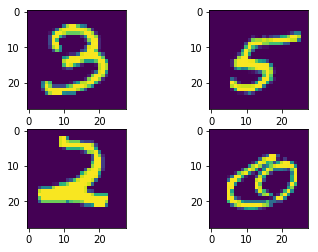

In [9]:
plt.figure(1)
plt.subplot(221)
plt.imshow(X_train[13][:,:,0])

plt.subplot(222)
plt.imshow(X_train[690][:,:,0])

plt.subplot(223)
plt.imshow(X_train[2375][:,:,0])

plt.subplot(224)
plt.imshow(X_train[42013][:,:,0])
plt.show()

Our variational autoencoder requires three parts:  

##### 1. An encoder network that learns the parameters (mean and variance) of the underlying latent distribution  
This encoder is a CNN with 4 conv2D layers. You'll notice it has two output layers, one for the latent distribution mean (z_mu) and the other for its variance (z_log_sigma)

In [10]:
img_shape = (28, 28, 1)    # for MNIST
batch_size = 16
latent_dim = 2  # Number of latent dimension parameters

# Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', 
                  activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

# Two outputs, latent mean and (log)variance
z_mu = layers.Dense(latent_dim)(x)
z_log_sigma = layers.Dense(latent_dim)(x)

##### 2. A means of randomly sampling a point from that distribution  
Here we make a function that does the sampling from the latent distribution described by z_mu and z_log_sigma. Because compling the model in Keras requires that everything in our VAE be a layer object, we wrap the sampling function in a Lambda layer.

In [11]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = layers.Lambda(sampling)([z_mu, z_log_sigma])

##### 3. A decoder network to map that point back into reconstructed image 


In [12]:
# decoder takes the latent distribution sample as input
decoder_input = layers.Input(K.int_shape(z)[1:])

# Expand to 784 total pixels
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# reshape
x = layers.Reshape(shape_before_flattening[1:])(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
x = layers.Conv2DTranspose(32, 3,
                           padding='same', 
                           activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', 
                  activation='sigmoid')(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

The VAE is trained using two loss functions:  
1. 'Reconstruction loss' - This is the cross-entropy describing the errors between the samples from the latent distribution and the original inputs.  
2. The Kullback-Liebler divergence between the latent distribution and the prior.  


In [13]:
# construct a custom layer to calculate the loss
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

Note how the KL divergence acts as a regularization term. Now we instantiate the model...

In [14]:
# VAE model statement
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

C:\Users\rlvis\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  This is separate from the ipykernel package so we can avoid doing imports until


And now, we train our autoencoder!

In [15]:
vae.fit(x=X_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(X_valid, None))

Train on 65000 samples, validate on 5000 samples
Epoch 1/10
65000/65000 [==============================] - 234s 4ms/step - loss: 0.2227 - val_loss: 0.1958
Epoch 2/10
65000/65000 [==============================] - 210s 3ms/step - loss: 0.1926 - val_loss: 0.1914
Epoch 3/10
65000/65000 [==============================] - 213s 3ms/step - loss: 0.1882 - val_loss: 0.1878
Epoch 4/10
65000/65000 [==============================] - 206s 3ms/step - loss: 0.1857 - val_loss: 0.1872
Epoch 5/10
65000/65000 [==============================] - 207s 3ms/step - loss: 0.1841 - val_loss: 0.1856
Epoch 6/10
65000/65000 [==============================] - 207s 3ms/step - loss: 0.1828 - val_loss: 0.1837
Epoch 7/10
65000/65000 [==============================] - 206s 3ms/step - loss: 0.1819 - val_loss: 0.1868
Epoch 8/10
65000/65000 [==============================] - 205s 3ms/step - loss: 0.1811 - val_loss: 0.1822
Epoch 9/10
65000/65000 [==============================] - 205s 3ms/step - loss: 0.1806 - val_loss: 0.18

We can use the trained autoencoder to predict the latent distribution parameters on the validation data. I've colored them according to their 'label' class.

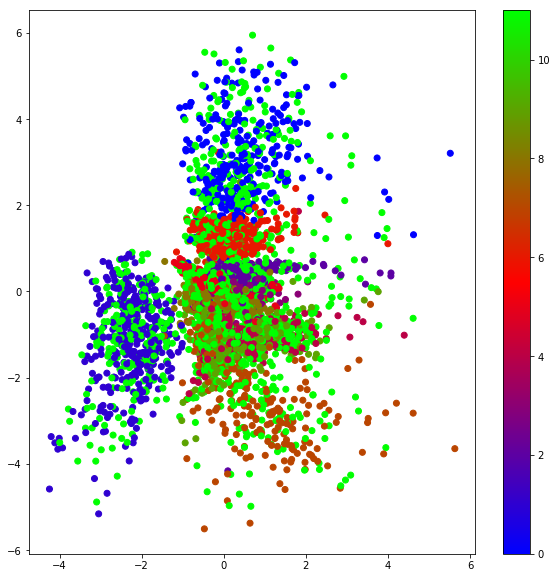

In [16]:
# Translate the validation set inputs into the latent space
encoder = Model(input_img, z_mu)
x_valid_encoded = encoder.predict(X_valid, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_valid_encoded[:, 0], x_valid_encoded[:, 1], c=y_valid, cmap='brg')
plt.colorbar()
plt.show()

Another neat thing you can do is take a peak at what samples from the latent space look like as we change the latent variables. What we end up with is a smoothly varying space where each digit transforms into the others as we dial the latent variables up and down.

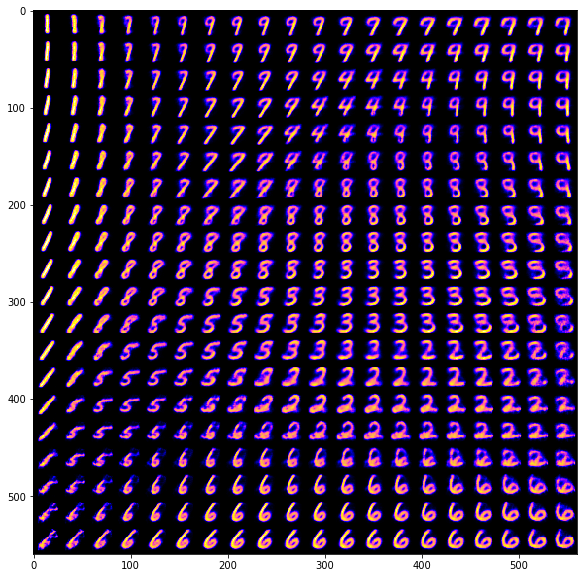

In [17]:
# Display a 2D manifold of the digits
n = 20  # figure with 20x20 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gnuplot2')
plt.show()  